In [5]:
# Time Series Forcasting with Prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [6]:
MedianHouseholdIncome = pd.read_csv('MedianHouseholdIncome.csv',
                   index_col=[0],
                  parse_dates=[0])
MedianHouseholdIncome.head()

,MEHOINUSNYA672N
observation_date,
1984-01-01,57910
1985-01-01,60100
1986-01-01,62600
1987-01-01,63840
1988-01-01,67470


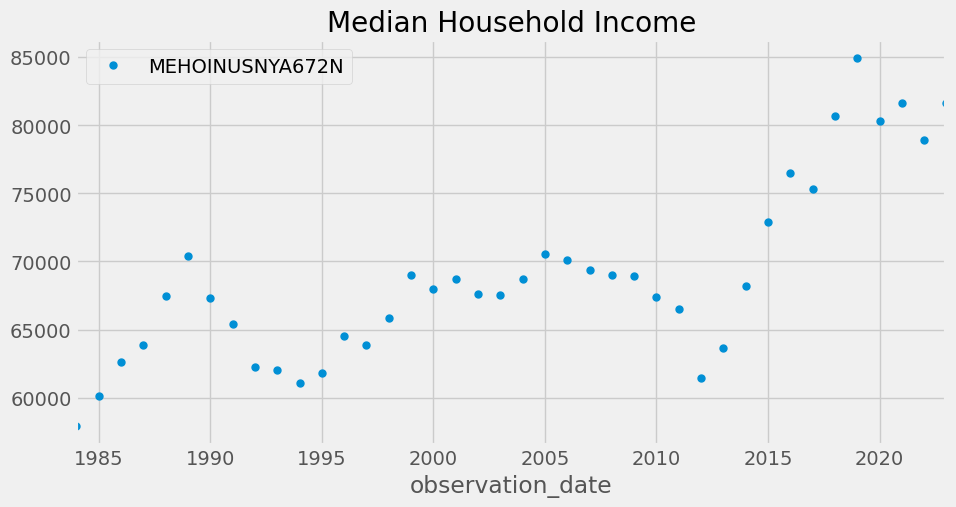

In [7]:
color_pal = sns.color_palette()
MedianHouseholdIncome.plot(style='.',
          figsize=(10, 5),
          ms=10,
          color=color_pal[0],
          title='Median Household Income')
plt.show()

In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(MedianHouseholdIncome, label='MEHOINUSNYA672N')
features_and_target = pd.concat([X, y], axis=1)

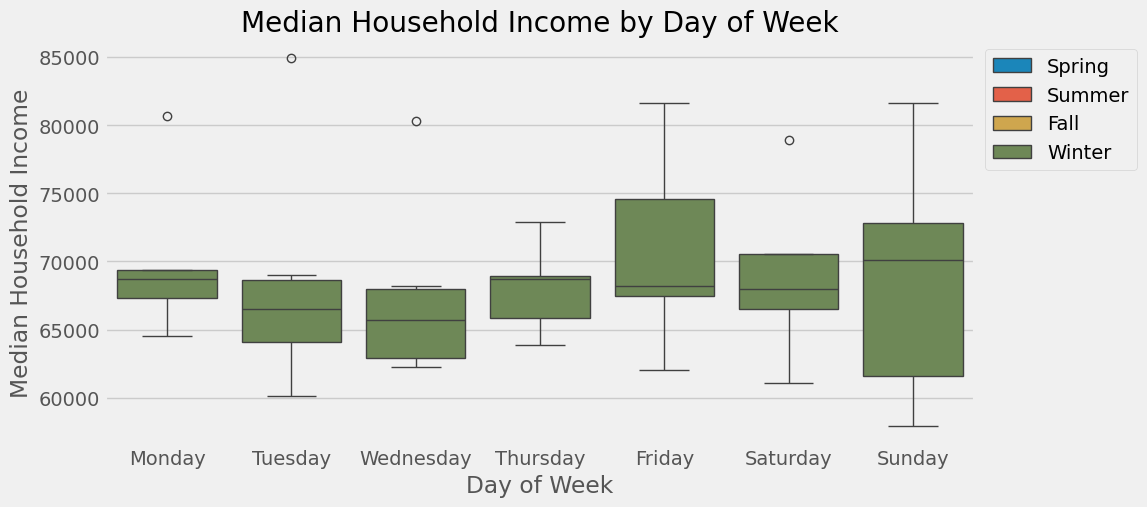

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='MEHOINUSNYA672N',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Median Household Income by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Median Household Income')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

16:43:51 - cmdstanpy - INFO - Chain [1] start processing
16:43:52 - cmdstanpy - INFO - Chain [1] done processing


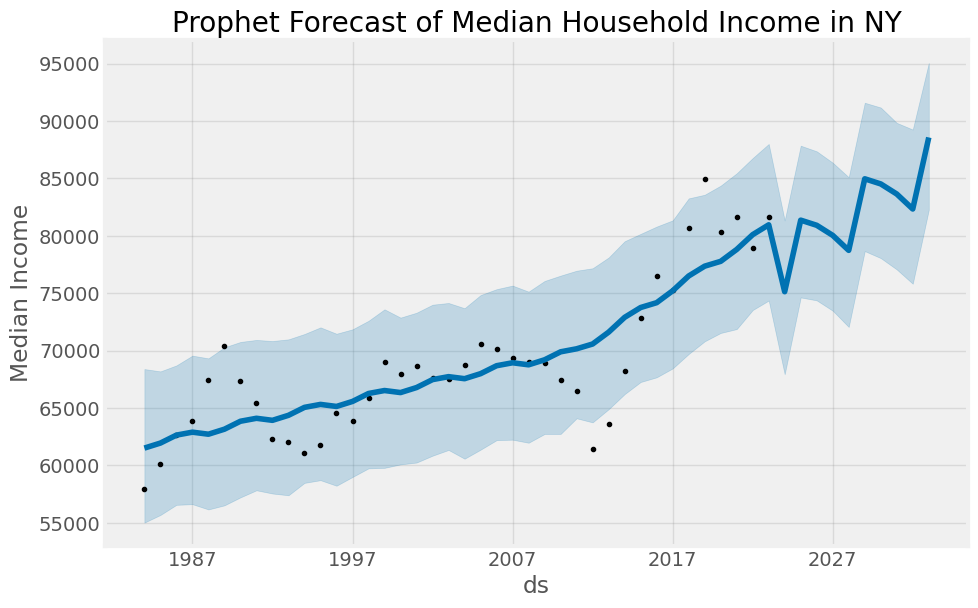

In [10]:
# Median Household Income NY analysis
df_income = pd.read_csv("MedianHouseholdIncome.csv")
df_income["observation_date"] = pd.to_datetime(df_income["observation_date"])
df_income = df_income.rename(columns={"observation_date": "ds", "MEHOINUSNYA672N": "y"})
m_income = Prophet(yearly_seasonality=True, interval_width=0.95)
m_income.fit(df_income)
future_income = m_income.make_future_dataframe(periods=10, freq="YE")
forecast_income = m_income.predict(future_income)
fig_income = m_income.plot(forecast_income)
plt.title("Prophet Forecast of Median Household Income in NY")
plt.ylabel("Median Income")
plt.show()

In [11]:
NYCMultifamily = pd.read_excel('NYCMultifamily.xlsx',
                   index_col=[0],
                  parse_dates=[0])
NYCMultifamily.head()



,Sales Vol,12 Mo\nSales Vol Growth,Number of Sales,Units Sold,Market\nSale Price/Unit,Market Cap Rate,Avg Transaction Price/Unit,Avg Transaction Cap Rate,Asset Value
Quarter,,,,,,,,,
2025 Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025 Q3 QTD,2.850000e+06,NaN,2.0,14.0,381363.87500,0.053683,203571.421875,0.064389,6.270190e+11
2025 Q2,1.625612e+09,0.286267,330.0,10397.0,380184.62500,0.053713,196519.781250,0.064028,6.249000e+11
2025 Q1,2.268584e+09,0.257455,349.0,8354.0,378864.75000,0.053687,309155.593750,0.064471,6.225407e+11
2024 Q4,2.646491e+09,0.196044,440.0,11106.0,372592.71875,0.053742,322192.750000,0.065529,6.122347e+11


16:43:52 - cmdstanpy - INFO - Chain [1] start processing
16:43:52 - cmdstanpy - INFO - Chain [1] done processing


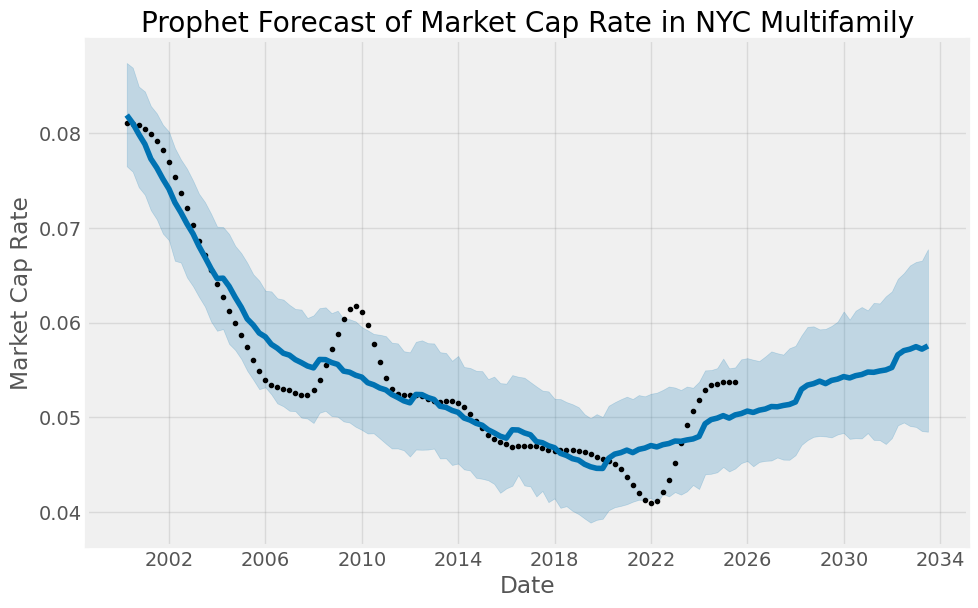

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# 1. Helper to turn "YYYY Qn" → quarter‑end date
def quarter_to_date(q):
    q = str(q).strip()
    parts = q.split()
    if len(parts) == 2 and parts[1].startswith('Q'):
        year = int(parts[0])
        quarter_num = int(parts[1][1])
        # month = last month of that quarter
        month = quarter_num * 3
        # take first of that month then roll to month end
        return pd.Timestamp(f'{year}-{month:02d}-01') + pd.offsets.MonthEnd(0)
    else:
        return pd.NaT

# 2. Build the prophet‑ready dataframe
NYCMultifamily = NYCMultifamily.copy()
# convert your index of "2025 Q4" style into a 'ds' column
NYCMultifamily['ds'] = (
    NYCMultifamily
    .index
    .to_series()
    .apply(quarter_to_date)
)
# rename your actual cap‑rate column to "y"
NYCMultifamily = NYCMultifamily.rename(
    columns={'Market Cap Rate': 'y'}  # ← use your real column name here
)

# drop any bad rows
df_prophet = (
    NYCMultifamily
    .reset_index(drop=True)[['ds','y']]
    .dropna(subset=['ds','y'])
)

# 3. Fit & forecast
m = Prophet(
    yearly_seasonality=True,
    interval_width=0.95,
)
m.fit(df_prophet)

# 32 future quarters ≈ 8 years → out to ~2028
future = m.make_future_dataframe(periods=32, freq='Q-DEC')
forecast = m.predict(future)

# 4. Plot
fig = m.plot(forecast)
plt.title("Prophet Forecast of Market Cap Rate in NYC Multifamily")
plt.ylabel("Market Cap Rate")
plt.xlabel("Date")
plt.show()


16:43:52 - cmdstanpy - INFO - Chain [1] start processing
16:43:52 - cmdstanpy - INFO - Chain [1] done processing


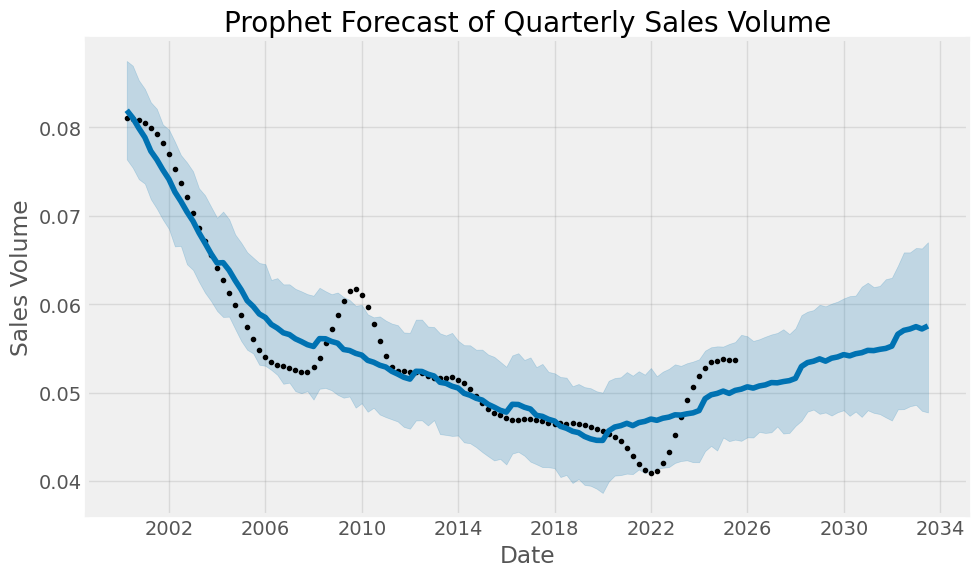

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# 1) Turn "YYYY Qn" → the actual quarter‑end date
def quarter_to_date(q):
    q = str(q).strip()
    parts = q.split()
    if len(parts) == 2 and parts[1].startswith('Q'):
        year = int(parts[0])
        quarter_num = int(parts[1][1])
        month = quarter_num * 3
        # build first‑of‑month then roll to month‑end
        return pd.Timestamp(f"{year}-{month:02d}-01") + pd.offsets.MonthEnd(0)
    else:
        return pd.NaT

# 2) Prepare your DataFrame
NYCMultifamily = NYCMultifamily.copy()
NYCMultifamily['ds'] = (
    NYCMultifamily
    .index
    .to_series()
    .apply(quarter_to_date)
)
# rename the actual sales‑volume column to "y"
NYCMultifamily = NYCMultifamily.rename(columns={"Sales Volume": "y"})

df_prophet = (
    NYCMultifamily
    .reset_index(drop=True)[['ds', 'y']]
    .dropna(subset=['ds', 'y'])
)

# 3) Fit Prophet
m_sales = Prophet(yearly_seasonality=True, interval_width=0.95)
m_sales.fit(df_prophet)

# 4) Make a future frame
#    32 quarters ≈ 8 years, with explicit quarter‑end freq
future_sales = m_sales.make_future_dataframe(periods=32, freq='Q-DEC')

# 5) Predict & Plot
forecast_sales = m_sales.predict(future_sales)
fig = m_sales.plot(forecast_sales)

plt.title("Prophet Forecast of Quarterly Sales Volume")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.tight_layout()
plt.show()


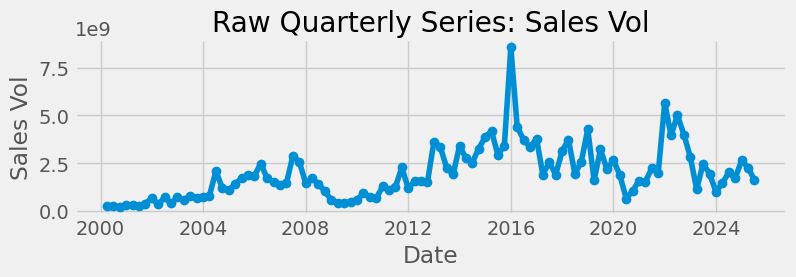

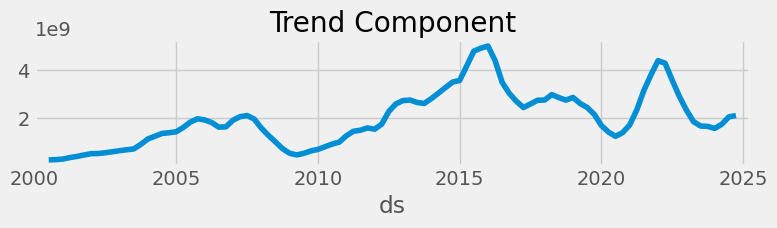

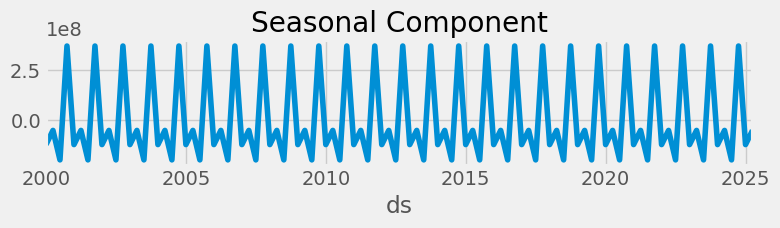

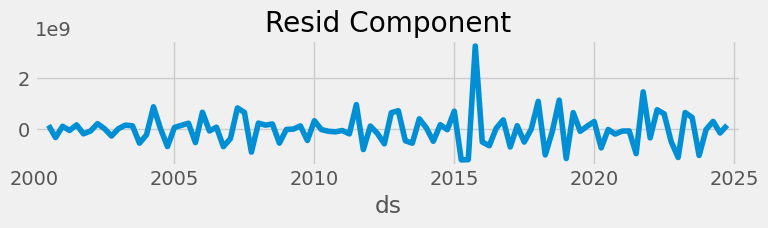

ADF Statistic = -2.049, p-value = 0.265


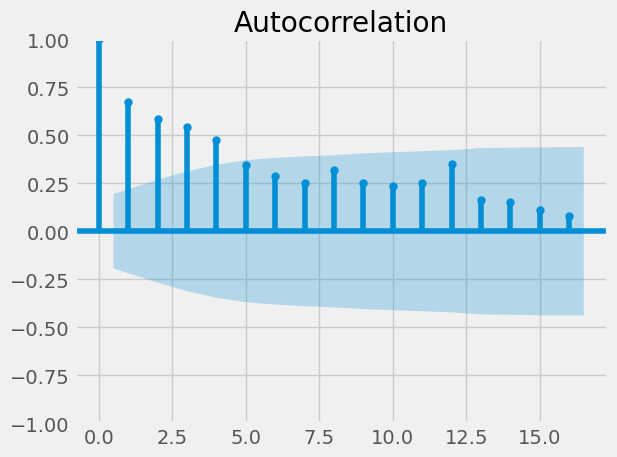

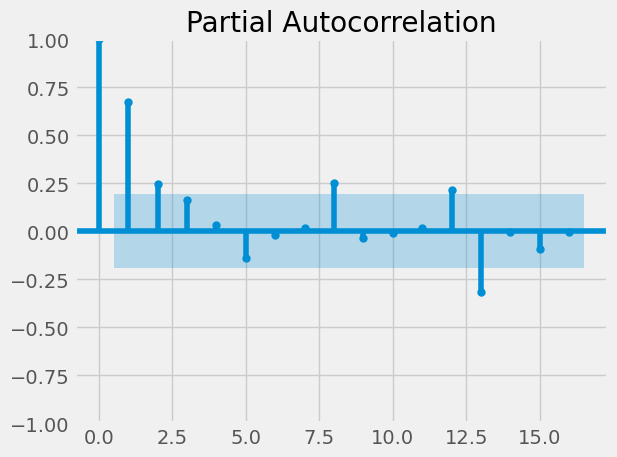

Best ARIMA order by AIC: (0, 2, 2)  (AIC=4441.4)
Avg. rolling MSE over each 4-quarter window: 1653733029475016960.00000


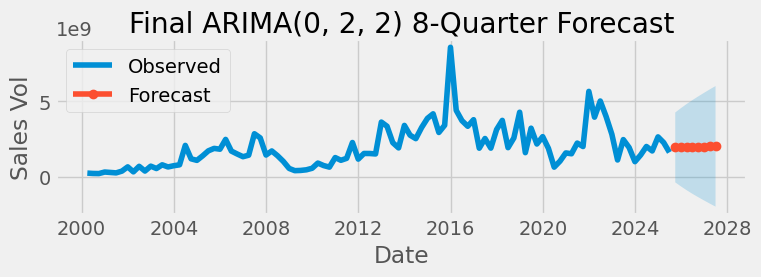

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# ————————————————
# 1) Load the data
# Make sure the file path matches where your Excel file actually lives.
# If it’s in the same folder as this script/notebook:
DATA_PATH = "NYCMultifamily.xlsx"
# Otherwise, adjust to "../data/NYCMultifamily.xlsx" or similar.

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Could not find data file at {DATA_PATH}")

df = pd.read_excel(DATA_PATH, index_col=0)

# ————————————————
# 2) Convert "YYYY Qn" → true quarter‑end Timestamp
def quarter_to_date(q):
    q = str(q).strip()
    parts = q.split()
    if len(parts) == 2 and parts[1].startswith('Q'):
        year = int(parts[0])
        quarter = int(parts[1][1])
        month = quarter * 3
        return pd.Timestamp(f"{year}-{month:02d}-01") + pd.offsets.MonthEnd(0)
    return pd.NaT

df['ds'] = df.index.to_series().apply(quarter_to_date)
df = df.set_index('ds').sort_index()

# ————————————————
# 3) Select & clean your target series
if 'y' in df.columns:
    series = df['y']
else:
    # fallback: first numeric column
    numeric_cols = df.select_dtypes(include='number').columns
    if len(numeric_cols) == 0:
        raise ValueError("No numeric column found for time series")
    series = df[numeric_cols[0]]

# coerce to numeric, drop bad values
series = pd.to_numeric(series, errors='coerce').dropna()
series.name = series.name or 'series'

# <<< FIX WARNING: ensure proper frequency and monotonic index >>>
series = series.sort_index()          # make sure dates are in ascending order
series = series.asfreq('Q-DEC')       # assign quarterly frequency (Dec‐ending)

# ————————————————
# 4) Plot raw series
plt.figure(figsize=(8, 3))
plt.plot(series, marker='o')
plt.title(f"Raw Quarterly Series: {series.name}")
plt.xlabel("Date")
plt.ylabel(series.name)
plt.tight_layout()
plt.show()

# ————————————————
# 5) Seasonal decomposition (additive, period=4)
decomp = seasonal_decompose(series, model='additive', period=4)
for comp in ['trend', 'seasonal', 'resid']:
    plt.figure(figsize=(8, 2.5))
    getattr(decomp, comp).plot()
    plt.title(f"{comp.capitalize()} Component")
    plt.tight_layout()
    plt.show()

# ————————————————
# 6) Stationarity test (Augmented Dickey–Fuller)
adf_stat, pval, *_ = adfuller(series)
print(f"ADF Statistic = {adf_stat:.3f}, p-value = {pval:.3f}")

# ————————————————
# 7) ACF & PACF diagnostics
plot_acf(series, lags=16)
plt.tight_layout(); plt.show()

plot_pacf(series, lags=16, method='ywm')
plt.tight_layout(); plt.show()

# ————————————————
# 8) Grid‑search ARIMA(p,d,q) by AIC (p,d,q from 0 to 2)
p = d = q = range(0, 3)
orders = list(itertools.product(p, d, q))
best_aic = np.inf
best_order = None

for order in orders:
    try:
        m = ARIMA(series, order=order).fit()
        if m.aic < best_aic:
            best_aic, best_order = m.aic, order
    except Exception:
        continue

print(f"Best ARIMA order by AIC: {best_order}  (AIC={best_aic:.1f})")

# ————————————————
# 9) Rolling‑window cross‑validation (last 4 quarters)
horizon = 4
errors = []

for end_ix in range(horizon, len(series) - horizon + 1):
    train = series.iloc[:end_ix]
    test  = series.iloc[end_ix : end_ix + horizon]
    model = ARIMA(train, order=best_order).fit()
    preds = model.forecast(steps=horizon)
    errors.append(mean_squared_error(test, preds))

print(f"Avg. rolling MSE over each {horizon}-quarter window: {np.mean(errors):.5f}")

# Or, if you prefer a single hold‑out:
# train, test = series.iloc[:-horizon], series.iloc[-horizon:]
# model = ARIMA(train, order=best_order).fit()
# preds = model.forecast(steps=horizon)
# print("Single hold-out MSE =", mean_squared_error(test, preds))

# ————————————————
# 10) Final fit & 8‑quarter forecast
final_mod = ARIMA(series, order=best_order).fit()
fc = final_mod.get_forecast(steps=8)
pred = fc.predicted_mean
ci   = fc.conf_int()

plt.figure(figsize=(8, 3))
plt.plot(series, label='Observed')
plt.plot(pred.index, pred, label='Forecast', marker='o')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2)
plt.title(f"Final ARIMA{best_order} 8‑Quarter Forecast")
plt.xlabel("Date")
plt.ylabel(series.name)
plt.legend()
plt.tight_layout()
plt.show()


=== Price Prediction ===
OLS   RMSE=4124.17, R2=0.612
Ridge RMSE=3642.57, R2=0.698
Lasso RMSE=3187.04, R2=0.769
RF    RMSE=2798.35, R2=0.822
SVR   RMSE=6770.18, R2=-0.044

=== FastRent Classification ===
Logistic Acc=0.954, AUC=0.981
RF       Acc=0.986, AUC=0.999
SVC      Acc=0.933, AUC=0.975

=== Cox PH Summary ===


<lifelines.CoxPHFitter: fitted with 1524 total observations, 960 right-censored observations>
             duration col = 'DOM'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1524
number of events observed = 564
   partial log-likelihood = -3966.18
         time fit was run = 2025-07-31 20:47:54 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Beds               0.16      1.18      0.07            0.03            0.29                1.03                1.34
Full Baths        -0.47      0.62      0.06           -0.58           -0.36                0.56                0.69
Half Baths        -0.07      0.93      0.09           -0.25            0.10                0.78                1.11
Total Square Feet -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                   cmp to     z      p  -log2(p)
covariate                                       
Beds                 0.00  2.45   0.01      6.14
Full Baths           0.00 -8.55 <0.005     56.13
Half Baths           0.00 -0.80   0.42      1.24
Total Square Feet    0.00 -0.73   0.47      1.10
---
Concordance = 0.64
Partial AIC = 7940.35
log-likelihood ratio test = 94.68 on 4 df
-log2(p) of ll-ratio test = 62.70

16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] done processing


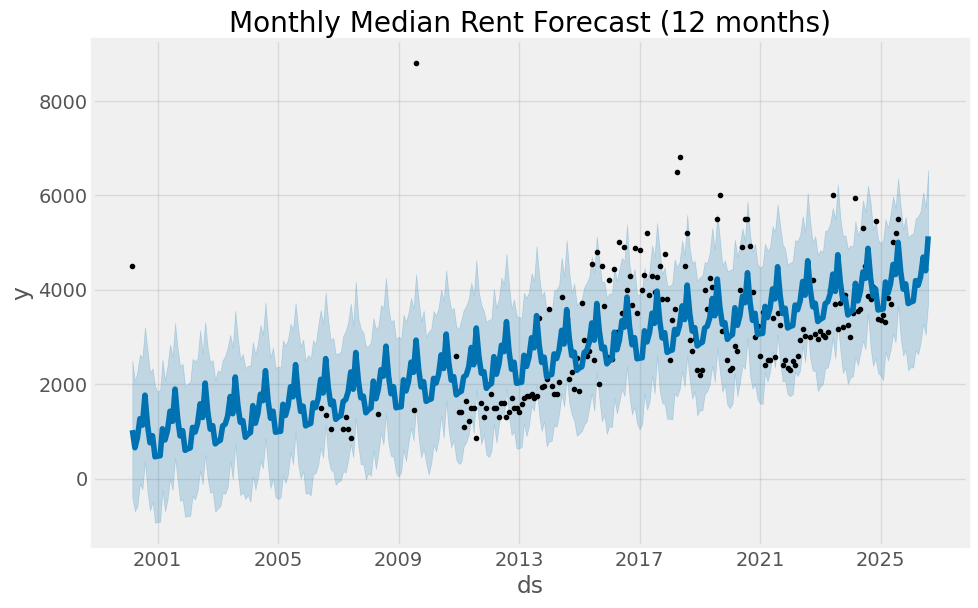


=== Cluster Counts ===
     KM_Cluster  DBSCAN_Cluster  Agglo_Cluster
-1          NaN            8517            NaN
 0       2404.0              25         4214.0
 1       1392.0              11         4486.0
 2       2373.0              12         1306.0
 3       3854.0              13           17.0
..          ...             ...            ...
 60         NaN              14            NaN
 61         NaN              11            NaN
 62         NaN              11            NaN
 63         NaN              16            NaN
 64         NaN              11            NaN

[66 rows x 3 columns]
Baseline RMSE: 6631.031841209288


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from sklearn.svm import SVR, SVC
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score

# time-series & survival
from prophet import Prophet
from lifelines import CoxPHFitter

# 1) Load & combine data
df_j = pd.read_excel('rentalsJamaica.xlsx')
df_n = pd.read_excel('rentalsNYC.xlsx')
df  = pd.concat([df_j, df_n], ignore_index=True)

# 2) Parse dates & compute DOM
df['List Date']   = pd.to_datetime(df['List Date'],   errors='coerce')
df['Rented Date'] = pd.to_datetime(df['Rented Date'], errors='coerce')
df['DOM'] = (df['Rented Date'] - df['List Date']).dt.days

# 3) Define feature lists using actual columns
num_feats = [
    'Beds', 
    'Full Baths ',    # note trailing space
    'Half Baths', 
    'Total Square Feet',
    'DOM'
 ]
cat_feats = [
    'Neighborhood',
    'City',
    'Building',
    'Listing Type',
    'Property Type',
    'Status'
 ]

# Convert 'Studio' and other non-numeric to 0 in numeric columns
for col in num_feats:
    df[col] = df[col].replace('Studio', 0)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure all categorical columns are string type
for col in cat_feats:
    df[col] = df[col].astype(str)

# Drop rows where target is NaN
df_model = df[num_feats + cat_feats + ['Price']].dropna(subset=['Price'])
X = df_model[num_feats + cat_feats].fillna(0)
y = df_model['Price']

# 4) Preprocessing pipeline
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_feats),
])

# 5) Price prediction (regression)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
models_reg = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RF': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

print("=== Price Prediction ===")
for name, m in models_reg.items():
    pipe = Pipeline([('prep', preproc), ('model', m)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f"{name:<5} RMSE={np.sqrt(mean_squared_error(y_test, preds)):.2f}, R2={r2_score(y_test, preds):.3f}")

# 6) Fast‑rent classification (DOM ≤ 30 days)
df['FastRent'] = (df['DOM'] <= 30).astype(int)
Xc, yc = df[num_feats + cat_feats].fillna(0), df['FastRent']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)
models_clf = {
    'Logistic': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVC': SVC(probability=True)
}

print("\n=== FastRent Classification ===")
for name, m in models_clf.items():
    pipe = Pipeline([('prep', preproc), ('model', m)])
    pipe.fit(Xc_train, yc_train)
    preds = pipe.predict(Xc_test)
    prob  = pipe.predict_proba(Xc_test)[:,1]
    print(f"{name:<8} Acc={accuracy_score(yc_test, preds):.3f}, AUC={roc_auc_score(yc_test, prob):.3f}")

# 7) Survival analysis (Cox PH)
surv_cols = [col for col in num_feats if col != 'DOM'] + ['DOM', 'FastRent']
surv_df = df[surv_cols].dropna().rename(columns={'FastRent':'event'})
cph = CoxPHFitter()
cph.fit(surv_df, duration_col='DOM', event_col='event')
print("\n=== Cox PH Summary ===")
cph.print_summary()

# 8) Trend forecasting (monthly median Price)
ts = (
    df[['List Date','Price']]
    .dropna()
    .set_index('List Date')
    .resample('M')['Price']
    .median()
    .reset_index()
    .rename(columns={'List Date':'ds','Price':'y'})
)
m = Prophet(yearly_seasonality=True)
m.fit(ts)
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
fig = m.plot(forecast)
plt.title('Monthly Median Rent Forecast (12 months)')
plt.show()

# 9) Clustering
features = preproc.fit_transform(df[num_feats + cat_feats].fillna(0))
df['KM_Cluster']     = KMeans(n_clusters=4, random_state=42).fit_predict(features)
df['DBSCAN_Cluster'] = DBSCAN(eps=0.5, min_samples=10).fit_predict(features)
df['Agglo_Cluster']  = AgglomerativeClustering(n_clusters=4).fit_predict(features)

print("\n=== Cluster Counts ===")
print(df[['KM_Cluster','DBSCAN_Cluster','Agglo_Cluster']].apply(pd.Series.value_counts))

baseline_rmse = np.sqrt(np.mean((y_test - y_train.mean())**2))
print("Baseline RMSE:", baseline_rmse)


In [ ]:
# Log-transform regression for all models
print("\n=== Log-Transformed Price Prediction ===")
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
for name, m in models_reg.items():
    pipe = Pipeline([('prep', preproc), ('model', m)])
    pipe.fit(X_train, y_train_log)
    preds_log = pipe.predict(X_test)
    preds = np.expm1(preds_log)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"{name:<5} RMSE={rmse:.2f}, R2={r2:.3f}")


=== Log-Transformed Price Prediction ===


OLS   RMSE=5037.00, R2=0.422
Ridge RMSE=4797.17, R2=0.476
Lasso RMSE=6879.66, R2=-0.078
